In [1]:
import struct
import numpy as np
import os.path
import math
import re
import numba
from scipy import stats
from pylab import *
##file manipulation
from astropy.io import ascii
from astropy.io import fits
from scipy.io import FortranFile
import h5py
import pickle
##os and other stuff
import time
import warnings
import os
import sys
from numba import jit
#for ulterior plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
plt.ion()

## to import the custom library in ipython
sys.path.insert(1, '/home/alin/Documents/physics_prog/cle/python/')
import importlib        ### to reload external files after changes are made within modules.
import cle_utils

## kr              transition index (the atom contains several radiative transitions, kr is in the order defined in the used ATOM file
##                 e.g. for Fe XIII kr=0 means 1074.7nm and kr=1 means 1079.8nm
##
## simpath_out     takes the path to the CLE OUT file.
## simpath_atmos   takes the path to the CLE OUT file.
##
## no_rot          is a binary argument used to not rotate q and u vectors from CLE.
##                 The CLE roune corona.f contains the definition of the reference direction.
##                 The Stokes is computed using a ref direction parallel to the z-axis [N-S] to a 
##                 polarization vector in the frame of (y,z) [E-W, N-S] in the plane of the sky. 
##                 The input numbers q,u are replaced with these componenttis.       


# colorbar function to have nice colorbars in figures
def colorbar(mappable):
   from mpl_toolkits.axes_grid1 import make_axes_locatable
   import matplotlib.pyplot as plt
   last_axes = plt.gca()
   ax = mappable.axes
   fig = ax.figure
   divider = make_axes_locatable(ax)
   cax = divider.append_axes("right", size="3.5%", pad=0.05)
   cbar = fig.colorbar(mappable, cax=cax)
   #cbar.formatter.set_powerlimits((4, 9))
   plt.sca(last_axes)
   return cbar

<Figure size 1080x1080 with 0 Axes>

In [3]:
# simpath_out=    '/home/alin/Documents/physics_prog/cle/test_cle_3dipole/OUT1_o'
# simpath_atmos=  '/home/alin/Documents/physics_prog/cle/test_cle_3dipole/ATMOS1_o'

# kr_out=0
# no_rot_out =1

# ##put everything from OUT in a variable
# s = cle_utils.out_params(simpath_out,kr_out,no_rot_out)


# ##put everything from ATMOS in a variable
# atm=cle_utils.atmos_params(simpath_atmos)
# ##save atmos VTK datacubes for paraview rendering
# #cle_utils.atmos2vtk(atm,"/home/alin/Desktop/REU_Aatiya_wave/","test_deg",bx=1,by=1,bz=1,nne=1,te=1)

In [13]:
## Integrated profiles and magnetic field components

## load 3 atmos files
atm1=cle_utils.atmos_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/A_DIPOLE/ATMOS')
atm2=cle_utils.atmos_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/B_DIPOLE//ATMOS')
atm3=cle_utils.atmos_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/C_DIPOLE//ATMOS')
## 
bx1=( np.average(atm1.bx,axis=0)+np.average(atm2.bx,axis=0)+np.average(atm3.bx,axis=0) )/3.
by1=( np.average(atm1.by,axis=0)+np.average(atm2.by,axis=0)+np.average(atm3.by,axis=0) )/3.
bz1=( np.average(atm1.bz,axis=0)+np.average(atm2.bz,axis=0)+np.average(atm3.bz,axis=0) )/3.

print("shape is:",atm1.nne.shape)

#nne1=(np.average(atm1.nne[60:90,:,:],axis=0)+np.average(atm2.nne[60:90,:,:],axis=0)+np.average(atm3.nne[90:120,:,:],axis=0)  )/3.
va=np.sum(atm1.nne,axis=0)
va[isnan(va)]=0
vb=np.sum(atm2.nne,axis=0)
vb[isnan(vb)]=0
vc=np.sum(atm3.nne,axis=0)
vc[isnan(vc)]=0

vaa=(np.count_nonzero(atm1.nne,axis=0))
vaa[isnan(vaa)]=0
vbb=(np.count_nonzero(atm2.nne,axis=0))
vbb[isnan(vbb)]=0
vcc=(np.count_nonzero(atm3.nne,axis=0))
vcc[isnan(vcc)]=0

nne1=(va+vb+vc)/(vaa+vbb+vcc)


#te1=(np.average(atm1.te[60:90,:,:],axis=0)+np.average(atm2.te[60:90,:,:],axis=0)+np.average(atm3.te[90:120,:,:],axis=0)  )/3.
va=np.sum(atm1.te,axis=0)
va[isnan(va)]=0
vb=np.sum(atm2.te,axis=0)
vb[isnan(vb)]=0
vc=np.sum(atm3.te,axis=0)
vc[isnan(vc)]=0

vaa=(np.count_nonzero(atm1.te,axis=0))
vaa[isnan(vaa)]=0
vbb=(np.count_nonzero(atm2.te,axis=0))
vbb[isnan(vbb)]=0
vcc=(np.count_nonzero(atm3.te,axis=0))
vcc[isnan(vcc)]=0

te1=(va+vb+vc)/(vaa+vbb+vcc)


#v1=(np.sum(atm1.v,axis=0)/np.count_nonzero(atm1.v,axis=0))+(np.sum(atm2.v,axis=0)/np.count_nonzero(atm2.v,axis=0) )+(np.sum(atm3.v,axis=0)/np.count_nonzero(atm3.v,axis=0) ) 
# va=np.sum(atm1.v,axis=0)/np.count_nonzero(atm1.v,axis=0)
# va[isnan(va)]=0
# vb=np.sum(atm2.v,axis=0)/np.count_nonzero(atm2.v,axis=0)
# vb[isnan(vb)]=0
# vc=np.sum(atm3.v,axis=0)/np.count_nonzero(atm3.v,axis=0)
# vc[isnan(vc)]=0

# vaa=(np.count_nonzero(atm1.v,axis=0)/np.count_nonzero(atm1.v,axis=0))
# vaa[isnan(vaa)]=0
# vbb=(np.count_nonzero(atm2.v,axis=0)/np.count_nonzero(atm2.v,axis=0))
# vbb[isnan(vbb)]=0
# vcc=(np.count_nonzero(atm3.v,axis=0)/np.count_nonzero(atm3.v,axis=0))
# vcc[isnan(vcc)]=0

# v1=(va+vb+vc)/(vaa+vbb+vcc)

va=np.sum(atm1.v,axis=0)
va[isnan(va)]=0
vb=np.sum(atm2.v,axis=0)
vb[isnan(vb)]=0
vc=np.sum(atm3.v,axis=0)
vc[isnan(vc)]=0

vaa=(np.count_nonzero(atm1.v,axis=0))
vaa[isnan(vaa)]=0
vbb=(np.count_nonzero(atm2.v,axis=0))
vbb[isnan(vbb)]=0
vcc=(np.count_nonzero(atm3.v,axis=0))
vcc[isnan(vcc)]=0

v1=(va+vb+vc)/(vaa+vbb+vcc)

#vt1=(np.average(atm1.vt[60:90,:,:],axis=0)+np.average(atm2.vt[60:90,:,:],axis=0)+np.average(atm3.vt[90:120,:,:],axis=0)   ) /3
vta=np.sum(atm1.vt,axis=0)
vta[isnan(vta)]=0
vtb=np.sum(atm2.vt,axis=0)
vtb[isnan(vtb)]=0
vtc=np.sum(atm3.vt,axis=0)
vtc[isnan(vtc)]=0

vtaa=(np.count_nonzero(atm1.vt,axis=0))
vtaa[isnan(vtaa)]=0
vtbb=(np.count_nonzero(atm2.vt,axis=0))
vtbb[isnan(vtbb)]=0
vtcc=(np.count_nonzero(atm3.vt,axis=0))
vtcc[isnan(vtcc)]=0


vt1=(vta+vtb+vtc)/(vtaa+vtbb+vtcc)

btot=np.sqrt(bx1*bx1+by1*by1+bz1*bz1)
# a=np.where(atm.te[75,:,:]==0)
# fig, plots = plt.subplots(nrows=2, ncols=4, figsize=(11, 9))
# plots[0,0].imshow(te1.T,extent=[0.8,1.5,-1.1,1.1])
# c1 =patches.Circle((0, 0),1, color='red')
# plots[0,0].add_patch(c1)

%matplotlib widget

fig, plots = plt.subplots(nrows=2, ncols=4, figsize=(11, 9))
ab=plots[0,0].imshow(bx1.T/1000,extent=[0.8,1.5,-0.8,0.8],vmin=-2,vmax=2)
colorbar(ab)
plots[0,0].set_title('B$_x$')
plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[0,0].set_xlabel('Y [R$_\odot$]')
c1 =patches.Circle((0, 0),1, color='black')
plots[0,0].add_patch(c1)

ab=plots[0,1].imshow(by1.T/1000,extent=[0.8,1.5,-0.8,0.8],vmin=-20,vmax=20)
plots[0,1].set_title('B$_y$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,1].add_patch(c1)

ab=plots[0,2].imshow(bz1.T/1000,extent=[0.8,1.5,-0.8,0.8],vmin=-30,vmax=30)
plots[0,2].set_title('B$_z$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,2].add_patch(c1)

ab=plots[0,3].imshow(btot.T/1000,extent=[0.8,1.5,-0.8,0.8],vmin=-0,vmax=40)#,cmap='Reds')
plots[0,3].set_title('|B$_{tot}$|')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,3].add_patch(c1)

ab=plots[1,0].imshow(nne1.T,extent=[0.8,1.5,-0.8,0.8],vmin=0,vmax=5e8,cmap='BuGn')
plots[1,0].set_title('$\\rho$')
colorbar(ab)
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')
c1 =patches.Circle((0, 0),1, color='black')
plots[1,0].add_patch(c1)

ab=plots[1,1].imshow(te1.T,extent=[0.8,1.5,-0.8,0.8],vmin=0,vmax=2.5e6,cmap='Reds')
plots[1,1].set_title('T$_e$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,1].add_patch(c1)

ab=plots[1,2].imshow(v1.T,extent=[0.8,1.5,-0.8,0.8],vmin=-40,vmax=40,cmap='bwr')
plots[1,2].set_title('LOS Speed')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,2].add_patch(c1)

ab=plots[1,3].imshow(vt1.T,extent=[0.8,1.5,-0.8,0.8],vmin=-0,vmax=25,cmap='BuGn')
plots[1,3].set_title('Turb. speed')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,3].add_patch(c1)

#plt.imshow(vaa+vbb+vcc)
plots[1,1].annotate('A', xy=(1.04,0.1), xytext=(1.04,0.3),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots[1,1].annotate('B', xy=(1.04,-0.02), xytext=(1.04,-0.27),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots[1,1].annotate('C', xy=(1.15,0.01), xytext=(1.3,0.01),arrowprops=dict(facecolor='black',arrowstyle="->"))




plt.tight_layout()


Length of buffer is 12201634
Length of buffer is 3699770
Length of buffer is 13681882
shape is: (800, 280, 600)


/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
plt.figure()
plt.plot(atm3.bx[:,130,270])
plt.plot(atm3.by[:,130,270])
plt.plot(atm3.bz[:,130,270])
print(np.log10(nne1[130,270]),bx1[130,270],by1[130,270],bz1[130,270])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

8.03148022230743 0.0025033950805664062 3.963764508565267 -2.3883899052937827


In [16]:
##### print(atm1.te.shape)
gg1=atm1.nne[:,:,310].copy()   ## old low-resolution version has 110 index
#gg1[:68,:]=0
#gg1[79:,:]=0
gg2=atm2.nne[:,:,340].copy()
#gg2[:10,:]=0
#gg2[20:,:]=0

gg3=atm3.nne[:,:,340].copy()*50

plt.figure(figsize=(10, 10))
plt.xlim(-0.1,1.5)
plt.imshow(gg1+gg2+gg3,extent=[0.8,1.5,-0.75,0.75],vmin=0,vmax=5e8,cmap='BuGn')
plt.ylabel('X [R$_\odot$]')
plt.xlabel('Y [R$_\odot$]')
plt.title("Ecliptic plane $xy$; $z=0$ ")

plt.annotate('Loop C', xy=(1.23,0.5), xytext=(1.34,0.5),arrowprops=dict(facecolor='black',arrowstyle="->"))
plt.annotate('Loop B', xy=(1.07,-0.25), xytext=(1.18,-0.25),arrowprops=dict(facecolor='black',arrowstyle="->"))
plt.annotate('Loops A', xy=(1.1,-0.01), xytext=(1.2,-0.01),arrowprops=dict(facecolor='black',arrowstyle="->"))

plt.plot([1,1],[-0.75,0.75],color='b')
plt.text(0.97,-0.73,'Apparent limb \n    observed',rotation=90,fontsize=10,color='b')
plt.text(0.65,-0.71,'Solar Limb',rotation=50,fontsize=10,color='k')
plt.text(1.43,0.02,'$\leftarrow$ to observer',rotation=90,fontsize=10)


alpha = np.arange(100)/99.
mn=43* np.pi/180
mx=138* np.pi/180
alpha = mn + (alpha)*(mx-mn)
plt.plot(np.sin(alpha),np.cos(alpha),'k',linewidth=.7)

plt.plot([0,0.83],[0,0.5],'k--',linewidth=.7)
plt.plot([0.83,1.2],[0.5,0.5],'k',linewidth=.7)

plt.plot([0,0.97],[0,-0.01],'k--',linewidth=.7)
plt.plot([0.97,1.08],[-0.01,-0.01],'k',linewidth=.7)

plt.plot([0,0.94],[0,-0.26],'k--',linewidth=.7)
plt.plot([0.94,1.05],[-0.26,-0.26],'k',linewidth=.7)
plt.text(-0.01,-0.05,'O',fontsize=8)

#angle definitions
plt.plot([0,0],[0,0.2],'k',linewidth=.7)

plt.text(0.06,0.09,'59$^\circ$',rotation=29,fontsize=7,color='k')
plt.text(0.1,0.015,'91$^\circ$',rotation=0,fontsize=7,color='k')
plt.text(0.11,-0.035,'105$^\circ$',rotation=-9,fontsize=7,color='k')

alpha = np.arange(100)/99.
mn=0* np.pi/180
mx=59* np.pi/180
alpha = mn + (alpha)*(mx-mn)
plt.plot(np.sin(alpha)/10,np.cos(alpha)/10,'k',linewidth=.7)

alpha = np.arange(100)/99.
mn=0* np.pi/180
mx=91* np.pi/180
alpha = mn + (alpha)*(mx-mn)
plt.plot(np.sin(alpha)/12,np.cos(alpha)/12,'k',linewidth=.7)

alpha = np.arange(100)/99.
mn=0* np.pi/180
mx=105* np.pi/180
alpha = mn + (alpha)*(mx-mn)
plt.plot(np.sin(alpha)/15,np.cos(alpha)/15,'k',linewidth=.7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [2]:
##plot IQUV - 10747
kr_out=0       ##transition indexes and rotation parameters.
no_rot_out =1

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/A_DIPOLE/OUT',kr_out,no_rot_out)
s1=s.data_full.T
s1q=s.data_q.T
ss1_i=s.data1.T
ss1_q=s.data2.T
ss1_u=s.data3.T
ss1_v=s.data4.T

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/B_DIPOLE/OUT',kr_out,no_rot_out)
s2=s.data_full.T
s2q=s.data_q.T
ss2_i=s.data1.T
ss2_q=s.data2.T
ss2_u=s.data3.T
ss2_v=s.data4.T

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/C_DIPOLE/OUT',kr_out,no_rot_out)
s3=s.data_full.T
s3q=s.data_q.T
ss3_i=s.data1.T
ss3_q=s.data2.T
ss3_u=s.data3.T
ss3_v=s.data4.T


<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full


In [4]:
##plot IQUV - 10798
kr_out=1
#%matplotlib widget

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/A_DIPOLE/OUT',kr_out,no_rot_out)
s12=s.data_full.T
s1q2=s.data_q.T
ss1_i2=s.data1.T
ss1_q2=s.data2.T
ss1_u2=s.data3.T
ss1_v2=s.data4.T

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/B_DIPOLE/OUT',kr_out,no_rot_out)
s22=s.data_full.T
s2q2=s.data_q.T
ss2_i2=s.data1.T
ss2_q2=s.data2.T
ss2_u2=s.data3.T
ss2_v2=s.data4.T

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/C_DIPOLE/OUT',kr_out,no_rot_out)
s32=s.data_full.T
s3q2=s.data_q.T
ss3_i2=s.data1.T
ss3_q2=s.data2.T
ss3_u2=s.data3.T
ss3_v2=s.data4.T
kr_out=0

<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full


In [21]:
## Save a pickle for inversion with DB-Invert

##sobs_array

##3 dipole 1074 simulation
i1=ss1_i+ss2_i+ss3_i
q1=ss1_q+ss2_q+ss3_q
u1=ss1_u+ss2_u+ss3_u
v1=ss1_v+ss2_v+ss3_v

## 3dipole 1079 simulation
i2=ss1_i2+ss2_i2+ss3_i2
q2=ss1_q2+ss2_q2+ss3_q2
u2=ss1_u2+ss2_u2+ss3_u2
v2=ss1_v2+ss2_v2+ss3_v2


## data size
xxl=i1.shape[1]
yyl=i1.shape[0]
wwl=

sobs=np.zeros((xxl,yyl,8),dtype=np.float64)
sobs[:,:,0]=i1.T
sobs[:,:,1]=q1.T
sobs[:,:,2]=u1.T
sobs[:,:,3]=v1.T
sobs[:,:,4]=i2.T
sobs[:,:,5]=q2.T
sobs[:,:,6]=u2.T
sobs[:,:,7]=v2.T

for i in np.arange(0,8):
    sobs[:,:,i]= sobs[:,:,i]/sobs[:,:,0]

    
##yobs_array
#[0.8,1.5,-1.1,1.1] size from CLEDB GRID.DAT for the 3dipole simulation
x0=0.8
y0=-1.1
dx=(1.5-0.8)/xxl
dy=(1.1-(-1.1))/yyl

yobs=np.empty((xxl,yyl),dtype=np.float_)
for xx in range(xxl):
    for yy in range(yyl):
        yobs[xx,yy]=np.sqrt((x0+(xx*dx))**2+(y0+(yy*dy))**2 )

## RMS is simple and unused for the moment
rms=np.ones((8),dtype=np.float_)
sobs.shape
xxl


/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


280

In [22]:
# # # Saving the objects:
with open('obsstokes_3dipole_hires.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump([sobs,yobs,rms,xxl,yyl],f)

In [14]:
## full data save
##sobs_array

##3 dipole 1074 simulation
i1=s1[:,:,:,0]+s2[:,:,:,0]+s3[:,:,:,0]
q1=s1[:,:,:,1]+s2[:,:,:,1]+s3[:,:,:,1]
u1=s1[:,:,:,2]+s2[:,:,:,2]+s3[:,:,:,2]
v1=s1[:,:,:,3]+s2[:,:,:,3]+s3[:,:,:,3]

# ## 3dipole 1079 simulation
i2=s12[:,:,:,0]+s22[:,:,:,0]+s32[:,:,:,0]
q2=s12[:,:,:,1]+s22[:,:,:,1]+s32[:,:,:,1]
u2=s12[:,:,:,2]+s22[:,:,:,2]+s32[:,:,:,2]
v2=s12[:,:,:,3]+s22[:,:,:,3]+s32[:,:,:,3]


# ## data size
xxl=i1.shape[0]
yyl=i1.shape[1]
wwl=i1.shape[2]
print(xxl,yyl,wwl)

sobs_full=np.zeros((xxl,yyl,wwl,8),dtype=np.float64)
sobs_full[:,:,:,0]=i1
sobs_full[:,:,:,1]=q1
sobs_full[:,:,:,2]=u1
sobs_full[:,:,:,3]=v1
sobs_full[:,:,:,4]=i2
sobs_full[:,:,:,5]=q2
sobs_full[:,:,:,6]=u2
sobs_full[:,:,:,7]=v2

sobs_a=np.zeros((xxl,yyl,wwl,8),dtype=np.float64)
sobs_a[:,:,:,0]=s1[:,:,:,0]
sobs_a[:,:,:,1]=s1[:,:,:,1]
sobs_a[:,:,:,2]=s1[:,:,:,2]
sobs_a[:,:,:,3]=s1[:,:,:,3]
sobs_a[:,:,:,4]=s12[:,:,:,0]
sobs_a[:,:,:,5]=s12[:,:,:,1]
sobs_a[:,:,:,6]=s12[:,:,:,2]
sobs_a[:,:,:,7]=s12[:,:,:,3]


sobs_b=np.zeros((xxl,yyl,wwl,8),dtype=np.float64)
sobs_b[:,:,:,0]=s2[:,:,:,0]
sobs_b[:,:,:,1]=s2[:,:,:,1]
sobs_b[:,:,:,2]=s2[:,:,:,2]
sobs_b[:,:,:,3]=s2[:,:,:,3]
sobs_b[:,:,:,4]=s22[:,:,:,0]
sobs_b[:,:,:,5]=s22[:,:,:,1]
sobs_b[:,:,:,6]=s22[:,:,:,2]
sobs_b[:,:,:,7]=s22[:,:,:,3]

sobs_c=np.zeros((xxl,yyl,wwl,8),dtype=np.float64)
sobs_c[:,:,:,0]=s3[:,:,:,0]
sobs_c[:,:,:,1]=s3[:,:,:,1]
sobs_c[:,:,:,2]=s3[:,:,:,2]
sobs_c[:,:,:,3]=s3[:,:,:,3]
sobs_c[:,:,:,4]=s32[:,:,:,0]
sobs_c[:,:,:,5]=s32[:,:,:,1]
sobs_c[:,:,:,6]=s32[:,:,:,2]
sobs_c[:,:,:,7]=s32[:,:,:,3]

600 280 30


In [13]:
# # # Saving the objects:
with open('obsstokes_3dipole_hires_fullspectra.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump([sobs_a,sobs_b,sobs_c,sobs_full,s1q,s1q2],f)

In [53]:
## check if everything is right with the array
plt.figure()
#plt.imshow(sobs[:,:,3].T)
plt.imshow(yobs.T)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
with open('outparams_3dipole_20210511.pkl','rb') as f:
   out = pickle.load(f)  

<Figure size 432x288 with 0 Axes>

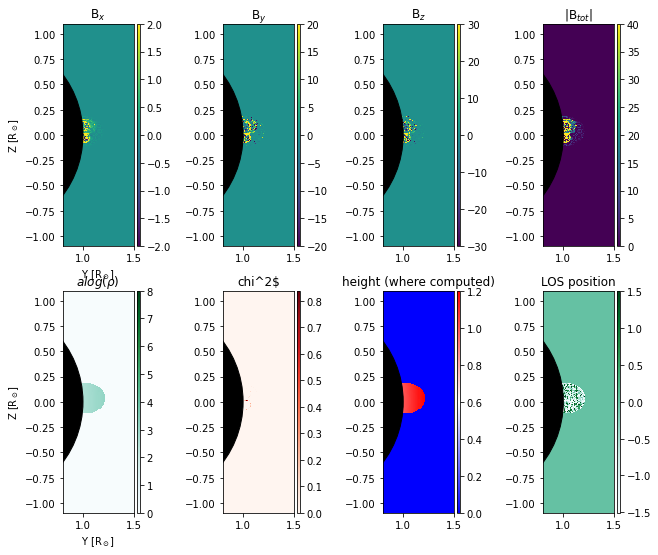

In [28]:
## plots of the inversion outputs
plt.figure()

fig, plots = plt.subplots(nrows=2, ncols=4, figsize=(11, 9))
ab=plots[0,0].imshow(out[:,:,0,7].T/100,extent=[0.8,1.5,-1.1,1.1],vmin=-2,vmax=2)
colorbar(ab)
plots[0,0].set_title('B$_x$')
plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[0,0].set_xlabel('Y [R$_\odot$]')
c1 =patches.Circle((0, 0),1, color='black')
plots[0,0].add_patch(c1)

ab=plots[0,1].imshow(out[:,:,0,8].T,extent=[0.8,1.5,-1.1,1.1],vmin=-20,vmax=20)
plots[0,1].set_title('B$_y$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,1].add_patch(c1)

ab=plots[0,2].imshow(out[:,:,0,9].T,extent=[0.8,1.5,-1.1,1.1],vmin=-30,vmax=30)
plots[0,2].set_title('B$_z$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,2].add_patch(c1)

ab=plots[0,3].imshow((out[:,:,0,7].T+out[:,:,0,8].T+out[:,:,0,9].T)/3.,extent=[0.8,1.5,-1.1,1.1],vmin=-0,vmax=40)#,cmap='Reds')
plots[0,3].set_title('|B$_{tot}$|')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0,3].add_patch(c1)

ab=plots[1,0].imshow(out[:,:,0,3].T*2.6,extent=[0.8,1.5,-1.1,1.1],vmin=0,vmax=8,cmap='BuGn')
plots[1,0].set_title('$alog(\\rho$)')
colorbar(ab)
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')
c1 =patches.Circle((0, 0),1, color='black')
plots[1,0].add_patch(c1)

ab=plots[1,1].imshow(out[:,:,0,1].T,extent=[0.8,1.5,-1.1,1.1],cmap='Reds')
plots[1,1].set_title('chi^2$')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,1].add_patch(c1)

ab=plots[1,2].imshow(out[:,:,0,3].T,extent=[0.8,1.5,-1.1,1.1],cmap='bwr')
plots[1,2].set_title('height (where computed)')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,2].add_patch(c1)

ab=plots[1,3].imshow(out[:,:,0,4].T,extent=[0.8,1.5,-1.1,1.1],cmap='BuGn')
plots[1,3].set_title('LOS position')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1,3].add_patch(c1)

plt.savefig('/home/alin/Desktop/3dipole_invert.png',dpi=100)

In [24]:
print(ss1_v.shape)
fig, plots0 = plt.subplots(nrows=1, ncols=4, figsize=(11, 7))
cd=plots0[0].imshow(((ss1_i+ss2_i+ss3_i)/3)/np.max((ss1_i+ss2_i+ss3_i)/3) ,extent=[0.8,1.5,-1.1,1.1],vmin=0,vmax=1,cmap="Blues")
colorbar(cd)
c1 =patches.Circle((0, 0),1, color='black')
plots0[0].add_patch(c1)
plots0[0].set_title('Normalized Stokes I')
plots0[0].annotate('A', xy=(1.04,0.1), xytext=(1.04,0.3),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots0[0].annotate('B', xy=(1.04,-0.02), xytext=(1.04,-0.27),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots0[0].annotate('C', xy=(1.15,0.01), xytext=(1.3,0.01),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots0[0].annotate('CS', xy=(1.04,0.01), xytext=(1.2,-0.25),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots0[0].annotate('D1', xy=(1.11,0.1), xytext=(1.25,0.25),arrowprops=dict(facecolor='black',arrowstyle="->"))
plots0[0].annotate('D2', xy=(1.02,-0.05), xytext=(0.95,-0.4),arrowprops=dict(facecolor='black',arrowstyle="->"))

ab=plots0[1].imshow(((ss1_v+ss2_v+ss3_v)/30)/((ss1_i+ss2_i+ss3_i)/3),extent=[0.8,1.5,-1.1,1.1],vmin=-0.01,vmax=0.01,cmap="RdBu")
plots0[1].set_title('Normalized Stokes V')
c1 =patches.Circle((0, 0),1, color='black')
plots0[1].add_patch(c1)
colorbar(ab)

ab=plots0[2].imshow(((ss1_q+ss2_q+ss3_q)/3)/((ss1_i+ss2_i+ss3_i)/3),extent=[0.8,1.5,-1.1,1.1],vmin=-0.05,vmax=0.05,cmap="RdBu")
plots0[2].set_title('Normalized Stokes Q')
c1 =patches.Circle((0, 0),1, color='black')
plots0[2].add_patch(c1)
colorbar(ab)

ab=plots0[3].imshow(((ss1_u+ss2_u+ss3_u)/3)/((ss1_i+ss2_i+ss3_i)/3),extent=[0.8,1.5,-1.1,1.1],vmin=-0.05,vmax=0.05,cmap="RdBu")
colorbar(ab)
plots0[3].set_title('Normalized Stokes U')
c1 =patches.Circle((0, 0),1, color='black')
plots0[3].add_patch(c1)


plots0[0].set_ylabel('Z [R$_\odot$]')
plots0[0].set_xlabel('Y [R$_\odot$]')
#plt.title('LS Coupling')
plt.tight_layout()

(600, 280)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [26]:
plt.figure()
plt.imshow(((ss1_i+ss2_i+ss3_i)/3)/np.max((ss1_i+ss2_i+ss3_i)/3))
#39,107; 1.20
print(ss1_i.shape)
print([ss3_i[107,39],ss3_q[107,39],ss3_u[107,39],ss3_v[107,39],ss3_i2[107,39],ss3_q2[107,39],ss3_u2[107,39],ss3_v2[107,39]])

#32,116 ;1.13
print([ss1_i[116,32],ss1_q[116,32],ss1_u[116,32],ss1_v[116,32],ss1_i2[116,32],ss1_q2[116,32],ss1_u2[116,32],ss1_v2[116,32]])

#26,104; 1.07
print([ss2_i[104,26],ss2_q[104,26],ss2_u[104,26],ss2_v[104,26],ss2_i2[104,26],ss2_q2[104,26],ss2_u2[104,26],ss2_v2[104,26]])



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(600, 280)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [25]:
print(s1.shape,s1q.shape)
fig, plots0 = plt.subplots(nrows=1, ncols=4, figsize=(11, 5))
#plt.imshow((ss1_i+ss2_i+ss3_i)/3)
#plots0[0].plot(s1q+10747,(s1[110,22,:,0]+s2[110,22,:,0]+s3[110,22,:,0]),label='Obs.')
plots0[0].plot(s1q+10747,(s1[110,22,:,0]),label='A')
plots0[0].plot(s1q+10747,(s2[110,22,:,0]),label='B')
plots0[0].plot(s1q+10747,(3000*s3[110,22,:,0]),label='C')
plots0[0].plot(s1q+10747,(s1[110,22,:,0]+s2[110,22,:,0]+s3[110,22,:,0]),label='Obs.',color='black')

plots0[0].set_title('Normalized Stokes I')
plots0[0].set_ylabel('Normalized Intensity')
plots0[0].set_xlabel('Wavelength [$\AA$]')
#plots0[0].annotate('x,y $\\approx$ 1.04,0.01 R$_\odot$', xy=(10747.5,0.75))
plots0[0].legend(loc=1,frameon=True)
fig.suptitle('(y,z) $\\approx$ (1.04,0.01) R$_\odot$')

plots0[1].plot(s1q+10747,(s1[110,22,:,3]),label='A')
plots0[1].plot(s1q+10747,(s2[110,22,:,3]),label='B')
plots0[1].plot(s1q+10747,(3000*s3[110,22,:,3]),label='C')
plots0[1].plot(s1q+10747,(s1[110,22,:,3]+s2[110,22,:,3]+s3[110,22,:,3]),label='Obs.',color='black')

plots0[1].set_title('Normalized Stokes V')
#plots0[1].legend(loc=1,frameon=True)

plots0[2].plot(s1q+10747,(s1[110,22,:,1]),label='A')
plots0[2].plot(s1q+10747,(s2[110,22,:,1]),label='B')
plots0[2].plot(s1q+10747,(3000*s3[110,22,:,1]),label='C')
plots0[2].plot(s1q+10747,(s1[110,22,:,1]+s2[110,22,:,1]+s3[110,22,:,1]),label='Obs.',color='black')

plots0[2].set_title('Normalized Stokes Q')

plots0[3].plot(s1q+10747,(s1[110,22,:,2]),label='A')
plots0[3].plot(s1q+10747,(s2[110,22,:,2]),label='B')
plots0[3].plot(s1q+10747,(3000*s3[110,22,:,2]),label='C')
plots0[3].plot(s1q+10747,(s1[110,22,:,2]+s2[110,22,:,2]+s3[110,22,:,2]),label='Obs.',color='black')

plots0[3].set_title('Normalized Stokes U')
plt.tight_layout()
fig.subplots_adjust(top=0.88)


(600, 280, 30, 5) (30,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
## plot locations with two profiles along LOS.
## to invert we need to integrate these!

## extent  [0.8,1.5,-1.1,1.1] 
## array size [70;219]
## dx (1.5-0.8)/70=0.01
## dy (1.1-(-1.1)/219)=0.01

## D1 [1.11,0.10]
## D2 [1.02,-0.06]
## D1 xy 0.8+x*0.01=1.11 -1.1+y*0.01=0.1  x=31 y=120
## D2 xy 0.8+x*0.01=1.02 -1.1+y*0.01=-0.06 x=22 y=105

In [10]:
## D1  - 10747
fig, plots2 = plt.subplots(nrows=1, ncols=4, figsize=(11, 5))
plots2[0].plot(s1q+10747,s1[120,31,:,0]/np.max(s1[120,31,:,0]),label='A')
plots2[0].plot(s1q+10747,s3[120,31,:,0]/np.max(s1[120,31,:,0]),label='C',color="C2")
plots2[0].plot(s1q+10747,(s1[120,31,:,0]+s3[120,31,:,0])/np.max(s1[120,31,:,0]),label='Obs.',color='black')

plots2[0].set_title('Normalized Stokes I')
plots2[0].set_ylabel('Normalized Intensity')
plots2[0].set_xlabel('Wavelength [$\AA$]')
plots2[0].legend(loc=1,frameon=True)
fig.suptitle('Fe XIII 1074.7nm Point D1 (y,z) $\\approx$ (1.11,0.1) R$_\odot$')

plots2[1].plot(s1q+10747,(s1[120,31,:,1]/np.max(s1[120,31,:,0])),label='A')
plots2[1].plot(s1q+10747,(s3[120,31,:,1]/np.max(s1[120,31,:,0])),label='C',color="C2")
plots2[1].plot(s1q+10747,(s1[120,31,:,1]+s3[120,31,:,1])/np.max(s1[120,31,:,0]),label='Obs.',color='black')
plots2[1].set_title('Normalized Stokes Q')

plots2[2].plot(s1q+10747,(s1[120,31,:,2]/np.max(s1[120,31,:,0])),label='A')
plots2[2].plot(s1q+10747,(s3[120,31,:,2]/np.max(s1[120,31,:,0])),label='C',color="C2")
plots2[2].plot(s1q+10747,(s1[120,31,:,2]+s3[120,31,:,2])/np.max(s1[120,31,:,0]),label='Obs.',color='black')
plots2[2].set_title('Normalized Stokes U')


plots2[3].plot(s1q+10747,(s1[120,31,:,3]/np.max(s1[120,31,:,0])),label='A')
plots2[3].plot(s1q+10747,(s3[120,31,:,3]/np.max(s1[120,31,:,0])),label='C',color="C2")
plots2[3].plot(s1q+10747,(s1[120,31,:,3]+s3[120,31,:,3])/np.max(s1[120,31,:,0]),label='Obs.',color='black')
plots2[3].set_title('Normalized Stokes V')


plt.tight_layout()
fig.subplots_adjust(top=0.88)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
## D1  - 10798
fig, plots2 = plt.subplots(nrows=1, ncols=4, figsize=(11, 5))
plots2[0].plot(s1q2+10798,s12[120,31,:,0]/np.max(s12[120,31,:,0]),label='A')
plots2[0].plot(s1q2+10798,s32[120,31,:,0]/np.max(s12[120,31,:,0]),label='C',color="C2")
plots2[0].plot(s1q2+10798,(s12[120,31,:,0]+s32[120,31,:,0])/np.max(s12[120,31,:,0]),label='Obs.',color='black')

plots2[0].set_title('Normalized Stokes I')
plots2[0].set_ylabel('Normalized Intensity')
plots2[0].set_xlabel('Wavelength [$\AA$]')
plots2[0].legend(loc=1,frameon=True)
fig.suptitle('Fe XIII 1079.8nm Point D1 (y,z) $\\approx$ (1.11,0.1) R$_\odot$')

plots2[1].plot(s1q2+10798,(s12[120,31,:,1]/np.max(s12[120,31,:,0])),label='A')
plots2[1].plot(s1q2+10798,(s32[120,31,:,1]/np.max(s12[120,31,:,0])),label='C',color="C2")
plots2[1].plot(s1q2+10798,(s12[120,31,:,1]+s32[120,31,:,1])/np.max(s12[120,31,:,0]),label='Obs.',color='black')
plots2[1].set_title('Normalized Stokes Q')

plots2[2].plot(s1q2+10798,(s12[120,31,:,2]/np.max(s12[120,31,:,0])),label='A')
plots2[2].plot(s1q2+10798,(s32[120,31,:,2]/np.max(s12[120,31,:,0])),label='C',color="C2")
plots2[2].plot(s1q2+10798,(s12[120,31,:,2]+s32[120,31,:,2])/np.max(s12[120,31,:,0]),label='Obs.',color='black')
plots2[2].set_title('Normalized Stokes U')


plots2[3].plot(s1q2+10798,(s12[120,31,:,3]/np.max(s12[120,31,:,0])),label='A')
plots2[3].plot(s1q2+10798,(s32[120,31,:,3]/np.max(s12[120,31,:,0])),label='C',color="C2")
plots2[3].plot(s1q2+10798,(s12[120,31,:,3]+s32[120,31,:,3])/np.max(s12[120,31,:,0]),label='Obs.',color='black')
plots2[3].set_title('Normalized Stokes V')


plt.tight_layout()
fig.subplots_adjust(top=0.88)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
#compute the totals for D1 to invert.
v_d1=np.zeros((8))
#I
v_d1[0]=np.sum(s1[120,31,:,0]+s3[120,31,:,0])
v_d1[4]=np.sum(s12[120,31,:,0]+s32[120,31,:,0])
#Q
v_d1[1]=np.sum(s1[120,31,:,1]+s3[120,31,:,1])
v_d1[5]=np.sum(s12[120,31,:,1]+s32[120,31,:,1])
#U
v_d1[2]=np.sum(s1[120,31,:,2]+s3[120,31,:,2])
v_d1[6]=np.sum(s12[120,31,:,2]+s32[120,31,:,2])
#V  sign is dependent on the slope peak signs of Stokes V -+=- and +-=+
v_d1[3]=-np.sum(np.abs(s1[120,31,:,3]+s3[120,31,:,3]))
v_d1[7]=-np.sum(np.abs(s12[120,31,:,3]+s32[120,31,:,3]))

print(v_d1)

[ 2.77147984e+00 -1.30364644e-02 -8.49817523e-03 -5.08774743e-02
  1.90001667e+00 -3.30449505e-04 -2.13886508e-04 -7.47483540e-02]


In [13]:
## D2  - 10747
fig, plots2 = plt.subplots(nrows=1, ncols=4, figsize=(11, 5))
plots2[0].plot(s1q+10747,s2[105,22,:,0]/np.max(s2[105,22,:,0]),label='B',color="C1")
plots2[0].plot(s1q+10747,s3[105,22,:,0]/np.max(s2[105,22,:,0]),label='C',color="C2")
plots2[0].plot(s1q+10747,(s2[105,22,:,0]+s3[105,22,:,0])/np.max(s2[105,22,:,0]),label='Obs.',color='black')

plots2[0].set_title('Normalized Stokes I')
plots2[0].set_ylabel('Normalized Intensity')
plots2[0].set_xlabel('Wavelength [$\AA$]')
plots2[0].legend(loc=1,frameon=True)
fig.suptitle('Fe XIII 1074.7nm Point D2 (y,z) $\\approx$ (1.02,-0.06) R$_\odot$')

plots2[1].plot(s1q+10747,(s2[105,22,:,1]/np.max(s2[105,22,:,0])),label='B',color="C1")
plots2[1].plot(s1q+10747,(s3[105,22,:,1]/np.max(s2[105,22,:,0])),label='C',color="C2")
plots2[1].plot(s1q+10747,(s2[105,22,:,1]+s3[105,22,:,1])/np.max(s2[105,22,:,0]),label='Obs.',color='black')
plots2[1].set_title('Normalized Stokes Q')

plots2[2].plot(s1q+10747,(s2[105,22,:,2]/np.max(s2[105,22,:,0])),label='B',color="C1")
plots2[2].plot(s1q+10747,(s3[105,22,:,2]/np.max(s2[105,22,:,0])),label='C',color="C2")
plots2[2].plot(s1q+10747,(s2[105,22,:,2]+s3[105,22,:,2])/np.max(s2[105,22,:,0]),label='Obs.',color='black')
plots2[2].set_title('Normalized Stokes U')


plots2[3].plot(s1q+10747,(s2[105,22,:,3]/np.max(s2[105,22,:,0])),label='B',color="C1")
plots2[3].plot(s1q+10747,(s3[105,22,:,3]/np.max(s2[105,22,:,0])),label='C',color="C2")
plots2[3].plot(s1q+10747,(s2[105,22,:,3]+s3[105,22,:,3])/np.max(s2[105,22,:,0]),label='Obs.',color='black')
plots2[3].set_title('Normalized Stokes V')


plt.tight_layout()
fig.subplots_adjust(top=0.88)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
## D2  - 10798
fig, plots2 = plt.subplots(nrows=1, ncols=4, figsize=(11, 5))
plots2[0].plot(s1q2+10798,s22[105,22,:,0]/np.max(s22[105,22,:,0]),label='B',color="C1")
plots2[0].plot(s1q2+10798,s32[105,22,:,0]/np.max(s22[105,22,:,0]),label='C',color="C2")
plots2[0].plot(s1q2+10798,(s22[105,22,:,0]+s32[105,22,:,0])/np.max(s22[105,22,:,0]),label='Obs.',color='black')

plots2[0].set_title('Normalized Stokes I')
plots2[0].set_ylabel('Normalized Intensity')
plots2[0].set_xlabel('Wavelength [$\AA$]')
plots2[0].legend(loc=1,frameon=True)
fig.suptitle('Fe XIII 1079.8nm Point D2 (y,z) $\\approx$ (1.02,-0.06) R$_\odot$')

plots2[1].plot(s1q2+10798,(s22[105,22,:,1]/np.max(s22[105,22,:,0])),label='B',color="C1")
plots2[1].plot(s1q2+10798,(s32[105,22,:,1]/np.max(s22[105,22,:,0])),label='C',color="C2")
plots2[1].plot(s1q2+10798,(s22[105,22,:,1]+s32[105,22,:,1])/np.max(s22[105,22,:,0]),label='Obs.',color='black')
plots2[1].set_title('Normalized Stokes Q')

plots2[2].plot(s1q2+10798,(s22[105,22,:,2]/np.max(s22[105,22,:,0])),label='B',color="C1")
plots2[2].plot(s1q2+10798,(s32[105,22,:,2]/np.max(s22[105,22,:,0])),label='C',color="C2")
plots2[2].plot(s1q2+10798,(s22[105,22,:,2]+s32[105,22,:,2])/np.max(s22[105,22,:,0]),label='Obs.',color='black')
plots2[2].set_title('Normalized Stokes U')


plots2[3].plot(s1q2+10798,(s22[105,22,:,3]/np.max(s22[105,22,:,0])),label='B',color="C1")
plots2[3].plot(s1q2+10798,(s32[105,22,:,3]/np.max(s22[105,22,:,0])),label='C',color="C2")
plots2[3].plot(s1q2+10798,(s22[105,22,:,3]+s32[105,22,:,3])/np.max(s22[105,22,:,0]),label='Obs.',color='black')
plots2[3].set_title('Normalized Stokes V')

plt.tight_layout()
fig.subplots_adjust(top=0.88)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
#compute the totals for D2 to invert.
v_d2=np.zeros((8))
#I
v_d2[0]=np.sum(s2[105,22,:,0]+s3[105,22,:,0])
v_d2[4]=np.sum(s22[105,22,:,0]+s32[105,22,:,0])
#Q
v_d2[1]=np.sum(s2[105,22,:,1]+s3[105,22,:,1])
v_d2[5]=np.sum(s22[105,22,:,1]+s32[105,22,:,1])
#U
v_d2[2]=np.sum(s2[105,22,:,2]+s3[105,22,:,2])
v_d2[6]=np.sum(s22[105,22,:,2]+s32[105,22,:,2])
#V  sign is dependent on the slope peak signs of Stokes V -+=- and +-=+
v_d2[3]=-np.sum(np.abs(s2[105,22,:,3]+s3[105,22,:,3]))
v_d2[7]=-np.sum(np.abs(s22[105,22,:,3]+s32[105,22,:,3]))

print(v_d2)

[ 2.72472332e+00 -1.47195132e-04 -2.54103877e-05 -1.67518594e-01
  1.67537050e+00 -4.83628247e-06 -8.17960103e-07 -2.43508440e-01]


In [16]:
##plot Stokes I for all 3 in the old model!

%matplotlib widget

fig, plots0 = plt.subplots(nrows=2, ncols=3, figsize=(8, 7))

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/OUT1',kr_out,no_rot_out)
ss1=s.data1.T
# plots0[0,0].imshow(s.data1.T,aspect=0.5,extent=[0.8,1.5,-1.1,1.1])
# plots0[0,0].set_title('Stokes I - $\Theta_{LOS}$= 60')
# plots0[0,0].set_ylabel('Z [R$_\odot$]')
# plots0[0,0].set_xlabel('Y [R$_\odot$]')
# c1 =patches.Circle((0, 0),1, color='red')
# plots0[0,0].add_patch(c1)

s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/OUT',kr_out,no_rot_out)
ss2=s.data1.T
# plots0[0,1].imshow(s.data1.T,aspect=0.5,extent=[0.8,1.5,-1.1,1.1])
# plots0[0,1].set_title('Stokes I - $\Theta_{LOS}$= 90')
# c1 =patches.Circle((0, 0),1, color='blue')
# plots0[0,1].add_patch(c1)


s = cle_utils.out_params('/home/alin/Documents/physics_prog/cle/test_cle_3dipole/OUT3',kr_out,no_rot_out)
ss3=s.data1.T
# plots0[0,2].imshow(s.data1.T,aspect=0.5,extent=[0.8,1.5,-1.1,1.1])
# plots0[0,2].set_title('Stokes I - $\Theta_{LOS}$= 125')
# c1 =patches.Circle((0, 0),1, color='green')
# plots0[0,2].add_patch(c1)


plots0[1,1].imshow((ss1+ss2+ss3)/3,aspect=0.5,extent=[0.8,1.5,-1.1,1.1])
plots0[1,1].set_title('Stokes I - Combined')
c1 =patches.Circle((0, 0),1, color='black')
plots0[1,1].add_patch(c1)
plots0[1,1].set_ylabel('Z [R$_\odot$]')
plots0[1,1].set_xlabel('Y [R$_\odot$]')

plots0[1,0].axis('off')
plots0[1,2].axis('off')
#plt.title('LS Coupling')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
<class 'int'>
Full Stokes profiles were also outputted, stored in s.data_q, s.data_full
